In [65]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from datetime import timedelta,datetime
import random
random.seed(3)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")

In [63]:
# data import
countries_raw = pd.read_csv("COVID-19_Country_Over_Time.csv")
country_lst = pd.unique(countries_raw["Country"])
start_date = pd.Timestamp("12/31/19")
countries = {}
countries_stats = {}
for c in country_lst:
    temp = countries_raw[countries_raw["Country"]==c]
    temp["date"] = pd.to_datetime(temp["date"])
    temp["diff_time"] = (temp["date"]-start_date).dt.days
    temp["di_cases"] = temp["total_cases"].diff()
    temp["di_deaths"] = temp["total_deaths"].diff()
    temp.loc[temp["di_cases"]<0,"di_cases"] = 0
    temp.loc[temp["di_deaths"]<0,"di_deaths"] = 0
    temp = temp[1:].reset_index(drop=True)
    temp.set_index("date",inplace=True)
    # population
    popu = temp["Population_2020"][0]
    area = temp["Area"][0]
    popu_den = popu/area
    # days since first case
    infection_dates = temp.loc[temp["total_cases"]!=0,"diff_time"]
    if len(infection_dates) > 0: # some neighborhoods never had infections up to 04/27
        arrival_date = infection_dates[0]
    else:
        arrival_date = 0
    # tot_infected
    tot_infected = temp["total_cases"].iloc[-1]
    countries[c] = temp[["total_cases","total_deaths","di_cases","di_deaths","diff_time"]]
    countries_stats[c] = [popu,popu_den,arrival_date,tot_infected]

# aggregate - worldwide
date = pd.date_range(start="2020-01-01",end="2020-04-29",freq="D")
world = np.zeros(shape=(len(date),4))
world = pd.DataFrame(world,index=date,columns={"total_cases","total_deaths","di_cases","di_deaths"})
world["date"] = world.index
world["diff_time"] = (world["date"]-pd.Timestamp("2019-12-31")).dt.days
for c in country_lst:
    countries[c] = countries[c].reindex(date,fill_value=0)
    world["total_cases"] += countries[c]["total_cases"]
    world["total_deaths"] += countries[c]["total_deaths"]
    world["di_cases"] += countries[c]["di_cases"]
    world["di_deaths"] += countries[c]["di_deaths"]
    world.fillna(0,inplace=True)
world

/Users/fionaguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/fionaguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/fionaguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,di_cases,total_cases,total_deaths,di_deaths,date,diff_time
2020-01-01,0.0,27.0,0.0,0.0,2020-01-01,1
2020-01-02,0.0,27.0,0.0,0.0,2020-01-02,2
2020-01-03,17.0,44.0,0.0,0.0,2020-01-03,3
2020-01-04,0.0,44.0,0.0,0.0,2020-01-04,4
2020-01-05,15.0,59.0,0.0,0.0,2020-01-05,5
...,...,...,...,...,...,...
2020-04-25,72833.0,2730047.0,195761.0,5169.0,2020-04-25,116
2020-04-26,101722.0,2831769.0,201980.0,6219.0,2020-04-26,117
2020-04-27,83535.0,2915310.0,205899.0,3919.0,2020-04-27,118
2020-04-28,65421.0,2980731.0,210818.0,4919.0,2020-04-28,119


In [3]:
# pseudo R squared
# https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
def pseudoR2(model,mode = "CU"):
    # input: model: a GLM poisson or NB model
    #        mode: "CU" = Nagelkerke / Cragg & Uhler’s; "McFadden"; "ML" = Maximum Likelihood (Cox & Snell)
    L_f = model.llf # log-likelihood of full model
    L_i = model.llnull # log-likelihood of intercept
    N = model.nobs # number of data points
    
    r2McFadden = 1 - L_f/L_i
    G2 = -2 * (L_i - L_f)
    r2ML = 1 - np.exp(-G2/N)
    r2ML_max = 1 - np.exp(L_i * 2/N)
    r2CU = r2ML/r2ML_max
    if mode == "CU":
        r2 = r2CU
    if mode == "McFadden":
        r2 = r2McFadden
    if mode == "ML":
        r2 = r2ML
    if np.isnan(r2):
        r2 = 0
    return r2

In [79]:
def growthRate(data,data_type,var,mode,pR2_mode,poisson_chi2_cutoff,exp_cutoff,outlier_cutoff):
    # input: data - dictionary of pd dataframe or a single pd dataframe
    #        data_type = "dict" or "pd_df"
    #        poisson_expr - str
    #        var - variable (column name in pd dataframe) to be regressed on. eg "di_cases","di_deaths","infections"
    #        mode = "Poisson" or "NB"
    #        pR2_mode = "CU" or "McFadden" or "ML"
    #        poisson_chi2_cutoff - int, if chi2 larger than this, discard this data
    
    # initiate statistics to be recorded
    stats = {}
    stats["outlier"] = 0
    stats["fail_poisson"] = 0
    stats["poisson_insig"] = 0
    stats["nb_insig"] = 0
    stats["high_poisson_chi2"] = 0
    stats["poisson_small_p"] = 0
    stats["nb_small_p"] = 0
    
    poisson_expr = var + """ ~ diff_time"""
    ols_expr = """aux_ols ~ y_lambda - 1"""
    
    if data_type == "pd_df":
        temp_data = data.copy()
        data = {}
        data[0] = temp_data
    
    growth_rates = [] 
    intercepts = []
    subregions_used = []
    pRsquared = []
    std_errs = []
    cut_offs = []
    tot_infected = []
    predictions = {}
    
    for k,v in data.items():
        df = v
        Y,X = dmatrices(poisson_expr,df,return_type='dataframe')
        total_infect = np.sum(df[var])
        # exclude the outliers
        if len(df[df[var]!=0]) < 5 or total_infect < outlier_cutoff:
            stats["outlier"] += 1
            continue
        if exp_cutoff:
            # cut off upto exp ends using grid search, use the poisson model with best pseudo R^2 
            day_cnt = 0
            n_infected = 0
            pR2 = 0
            poisson = None
            cut_off = 0
            for i in range(len(df[var])):
                if df[var][i] != 0:
                    day_cnt += 1
                    n_infected += df[var][i]
                if day_cnt >= 5 and n_infected > outlier_cutoff:
                    temp = df[:i+1]
                    y,x = dmatrices(poisson_expr,temp,return_type='dataframe')
                    try:
                        temp_model = sm.GLM(y,x,family=sm.families.Poisson()).fit()
                    except:
                        stats["fail_poisson"] += 1
                        continue
                    temp_pR2 = pseudoR2(temp_model,mode=pR2_mode)
                    print(temp_pR2)
                    if temp_pR2 > pR2:
                        pR2 = temp_pR2
                        poisson = temp_model
                        cut_off = i
        else:
            poisson = sm.GLM(Y,X,family=sm.families.Poisson()).fit()
            pR2 = pseudoR2(poisson,mode=pR2_mode)
            cut_off = len(df)
        if pR2 == 0 or poisson == None or cut_off == 0:
            stats["poisson_insig"] += 1
            continue
        # check the significance of poisson regression
#         if poisson.pearson_chi2 > poisson_chi2_cutoff: # curves that don't follow exp trend (threshold 210 is inspected by eyes, not sure)
#             stats["high_poisson_chi2"] += 1
#             print(poisson.pearson_chi2)
#             continue
        if mode == "Poisson":
            if pR2 >= 0.3:
                final_model = poisson
                growth_rate = poisson.params["diff_time"]
                intercept = poisson.params["Intercept"]
                pRs = pR2
                std_err = poisson.bse["diff_time"]
            else:
                stats["poisson_small_p"] += 1
                continue
        else:
            # continue to Negative binomial
            df = df[:cut_off+1]
            y,x = dmatrices(poisson_expr,df,return_type='dataframe')
            # auxiliary OLS to fit the alpha in NB2
            df["y_lambda"] = poisson.mu
            df["aux_ols"] = df.apply(lambda x: ((x['di_cases'] - x['y_lambda'])**2 - x['di_cases']) / x['y_lambda'], axis=1)
            aux_olsr = smf.ols(ols_expr,df).fit()
            try:
                nb = sm.GLM(y,x,family=sm.families.NegativeBinomial(alpha=aux_olsr.params[0])).fit()
            except:
                stats["nb_insig"] += 1
                # use poisson result
                if pR2 >= 0.3:
                    final_model = poisson
                    growth_rate = poisson.params["diff_time"]
                    intercept = poisson.params["Intercept"]
                    pRs = pR2
                    std_err = poisson.bse["diff_time"]
                else:
                    stats["poisson_small_p"] += 1
                    continue
            nb_pR2 = pseudoR2(nb,mode=pR2_mode)
            if nb_pR2 >= 0:
                final_model = nb
                growth_rate = nb.params["diff_time"]
                intercept = nb.params["Intercept"]
                pRs = nb_pR2
                std_err = nb.bse["diff_time"]
            else:
                stats["nb_small_p"] += 1
                continue
        growth_rates.append(growth_rate)
        intercepts.append(intercept)
        subregions_used.append(k)
        pRsquared.append(pRs)
        std_errs.append(std_err)
        cut_offs.append(cut_off)
        tot_infected.append(total_infect)
        predictions[k] = final_model.predict(X)
        
    results = pd.DataFrame({"Growth Rate":growth_rates,"intercepts":intercepts,"pR2":pRsquared,"std_error":std_errs,"cut_offs":cut_offs,"tot_infected":tot_infected},index=subregions_used)
    return [results,predictions,stats]

In [12]:
countries_infected_results,c_i_pred,c_i_stats = growthRate(countries,"dict","di_cases","NB","McFadden",500,30)
countries_deaths_results,c_d_pred,c_d_stats = growthRate(countries,"dict","di_deaths","NB","McFadden",500,15)
world_infected_results,w_i_pred,w_i_stats = growthRate(world,"pd_df","di_cases","NB","McFadden",500,30)
world_deaths_results,w_d_pred,w_d_stats = growthRate(world,"pd_df","di_deaths","NB","CU",500,20)

/Users/fionaguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/fionaguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
print(len(countries_infected_results["Growth Rate"]))
print(len(countries_deaths_results["Growth Rate"]))

171
77


In [13]:
print(c_i_stats,c_d_stats,w_i_stats,w_d_stats)

{'outlier': 36, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 4, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0} {'outlier': 127, 'fail_poisson': 0, 'poisson_insig': 3, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0} {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0} {'outlier': 0, 'fail_poisson': 0, 'poisson_insig': 0, 'nb_insig': 0, 'high_poisson_chi2': 0, 'poisson_small_p': 0, 'nb_small_p': 0}


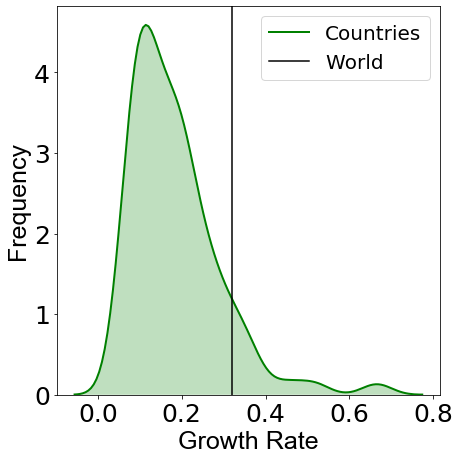

In [56]:
# Infected
# Figure 1(d)
fig = plt.figure(figsize=[6.5,6.5])
plt.xlabel("Infection Growth Rate",fontname="Arial", fontsize=25)
plt.ylabel("Frequency",fontname="Arial", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.title("Growth Rates Daily Increase of Infected",fontname="Arial", fontsize=15)
p_i = sns.distplot(countries_infected_results["Growth Rate"],hist=False, kde=True, 
             bins=40, color = "green",
             kde_kws={'linewidth': 2,"shade": True},label = "Countries")

p_n = plt.axvline(x=world_infected_results["Growth Rate"][0],color="black",label="World")
plt.legend(fontsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


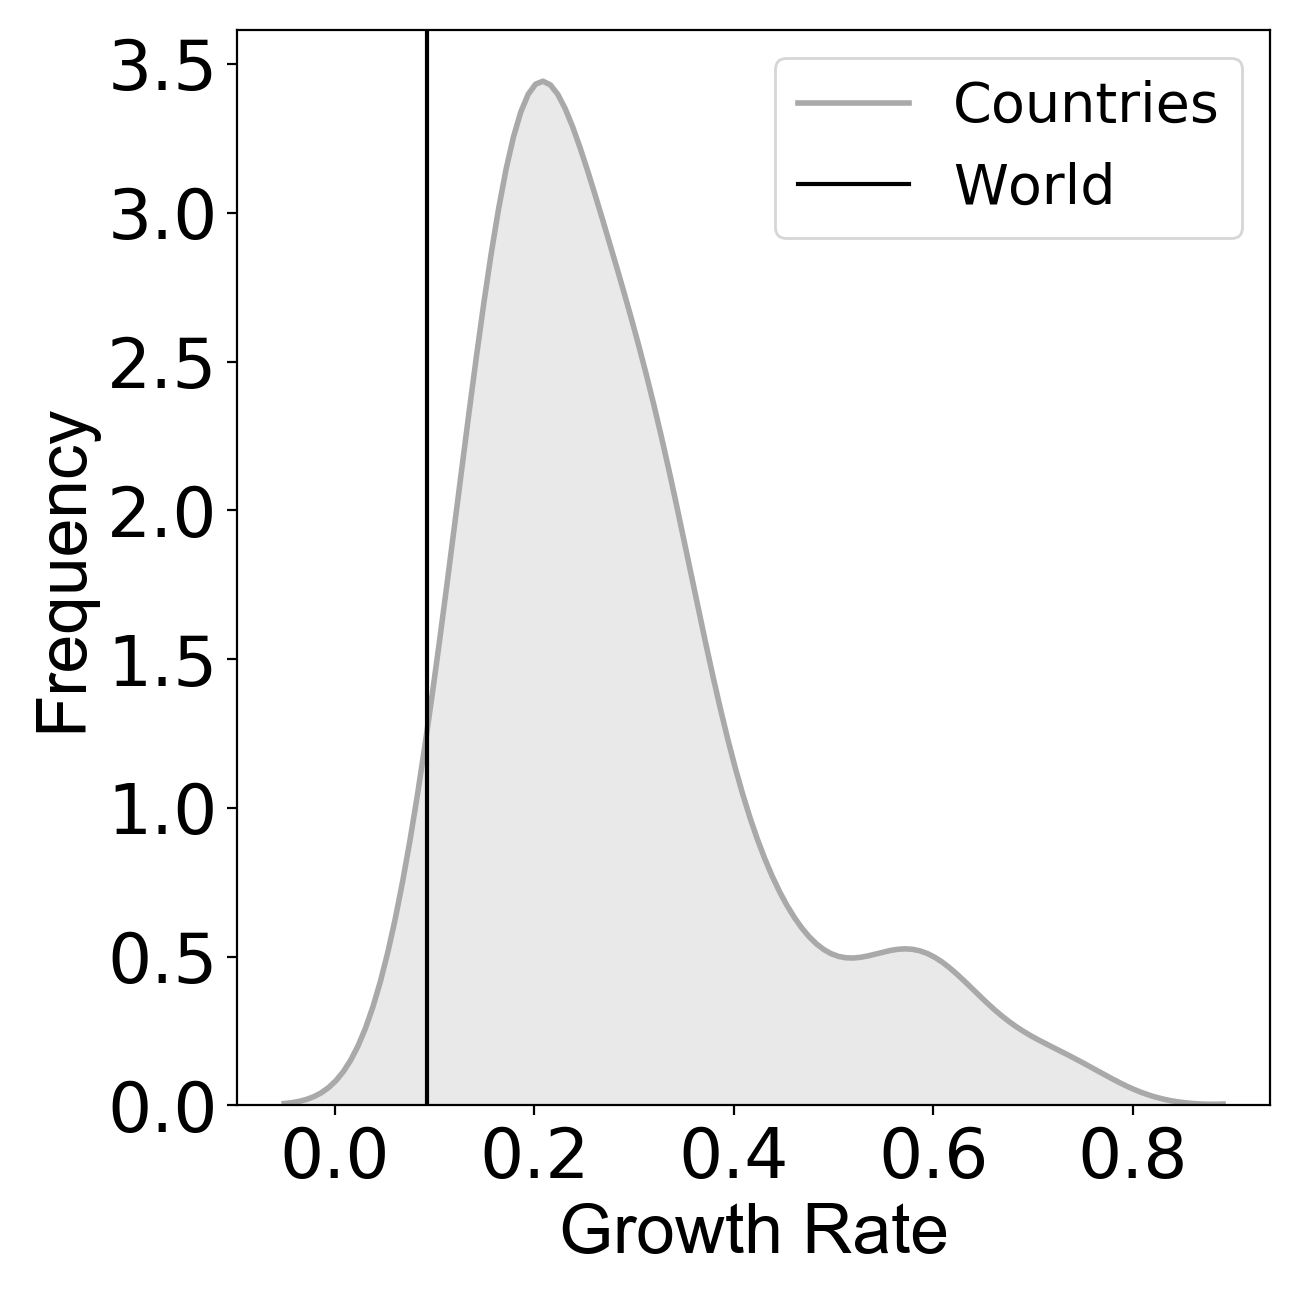

0    0.001436
Name: pR2, dtype: float64


In [74]:
# Infected
# Figure 1(d)
fig = plt.figure(figsize=[6.5,6.5])
plt.xlabel("Death Growth Rate",fontname="Arial", fontsize=25)
plt.ylabel("Frequency",fontname="Arial", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.title("Growth Rates Daily Increase of Infected",fontname="Arial", fontsize=15)
p_d = sns.distplot(countries_deaths_results["Growth Rate"], hist=False,kde=True, 
             bins=40, color = "darkgrey",
             kde_kws={'linewidth': 2,"shade": True},label = "Countries")
p_n = plt.axvline(x=world_deaths_results["Growth Rate"][0],color="black",label="World")
plt.legend(fontsize=20)
plt.tight_layout()


0.2901728619338184
0.2874333869849289
0.33554851194631646
0    0.318696
Name: Growth Rate, dtype: float64


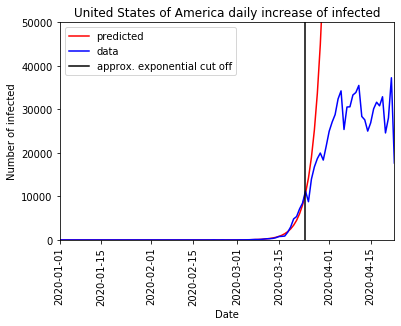

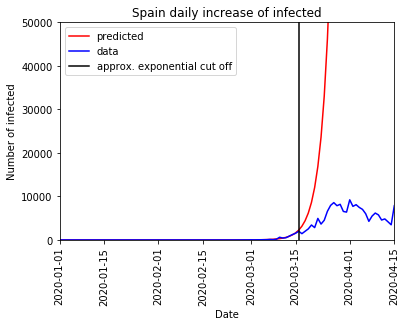

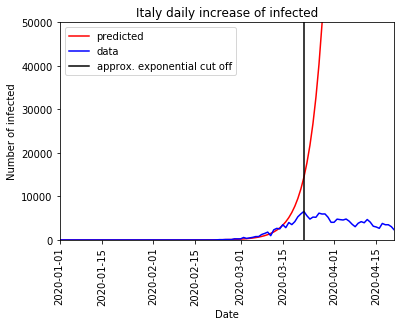

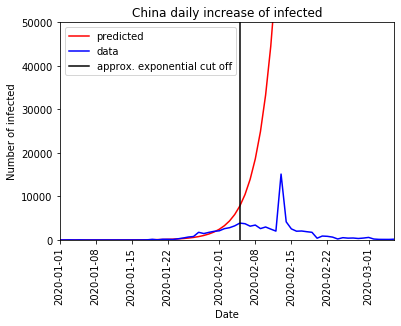

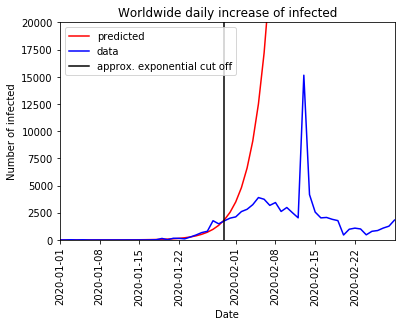

In [47]:
# infected
top_i = countries_infected_results.sort_values(by=["tot_infected"],ascending=False).index[:3]
for s in ["United States of America","Spain","Italy","China"]:
    plt.figure()
    plt.xlim(pd.Timestamp("2020-01-01"),countries[s].index[countries_infected_results["cut_offs"][s]+30])
    plt.ylim((0,50000))
    plt.title(s+" daily increase of infected")
    plt.plot(c_i_pred[s],color="red",label="predicted")
    plt.plot(countries[s]["di_cases"],color = "blue",label="data")
    plt.axvline(x=countries[s].index[countries_infected_results["cut_offs"][s]],color="black",label="approx. exponential cut off")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Number of infected")
    plt.xticks(rotation=90)
# plot world - pred & data & cutoff
plt.figure()
plt.xlim(pd.Timestamp("2020-01-01"),world.index[world_infected_results["cut_offs"]+30])
plt.ylim((0,20000))
plt.title("Worldwide daily increase of infected")
plt.plot(w_i_pred[0],color="red",label="predicted")
plt.plot(world["di_cases"],color = "blue",label="data")
plt.axvline(x=world.index[world_infected_results["cut_offs"]],color="black",label="approx. exponential cut off")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of infected")
plt.xticks(rotation=90)

print(countries_infected_results["Growth Rate"]["China"])
print(countries_infected_results["Growth Rate"]["United States of America"])
print(countries_infected_results["Growth Rate"]["Spain"])
print(world_infected_results["Growth Rate"][0])




<IPython.core.display.Javascript object>


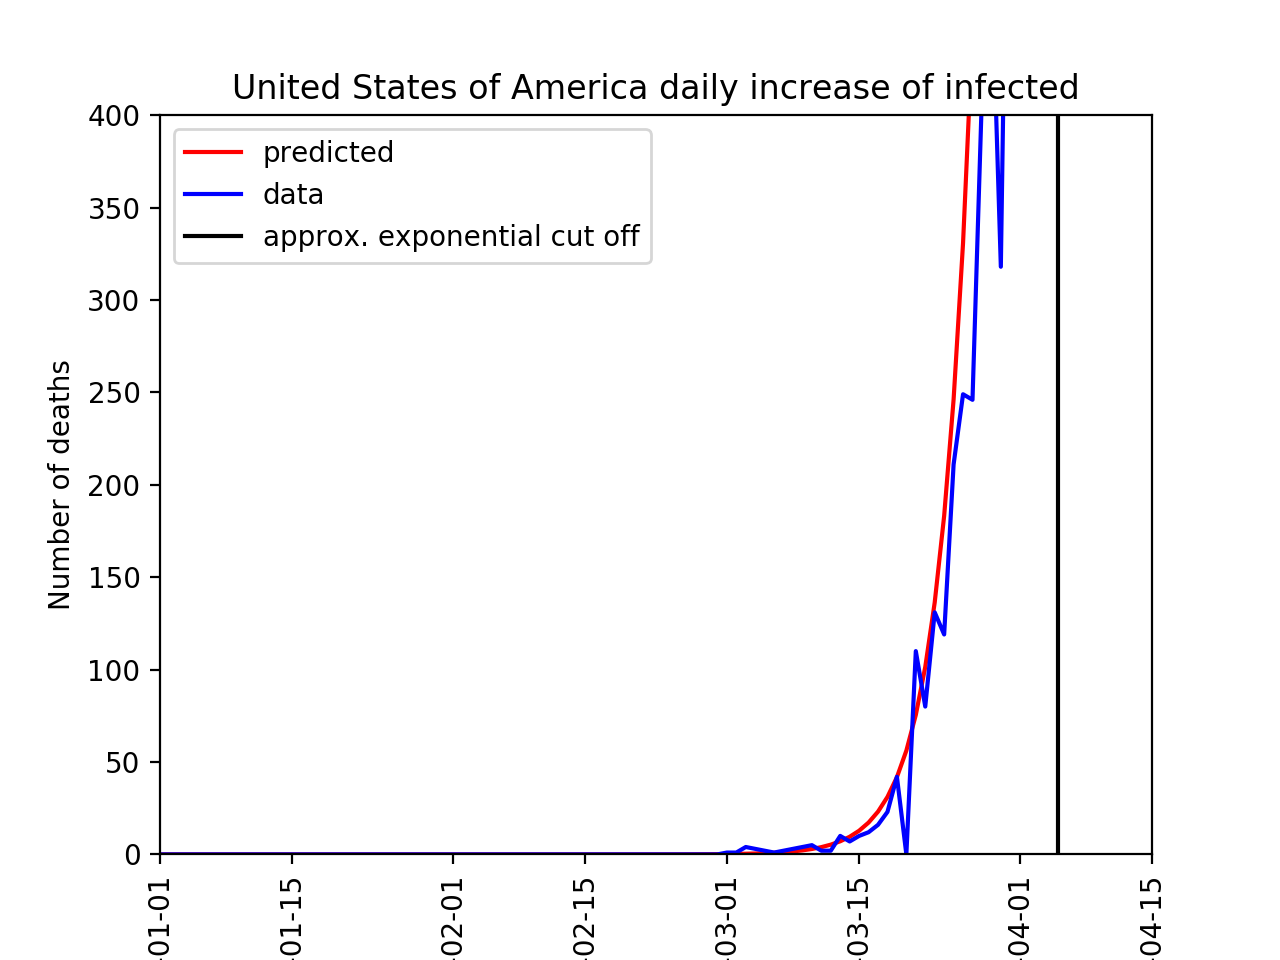

<IPython.core.display.Javascript object>


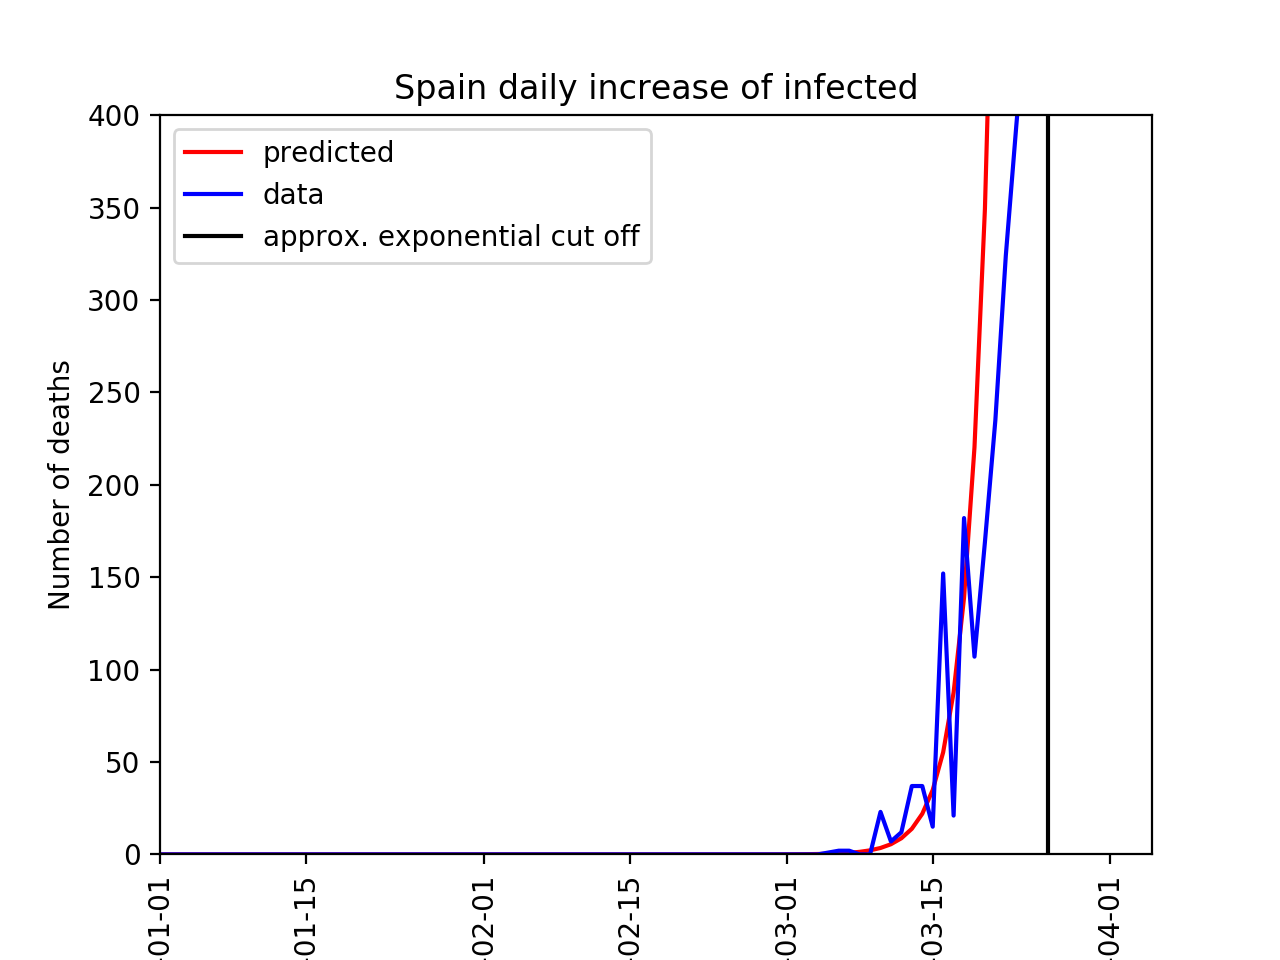

<IPython.core.display.Javascript object>


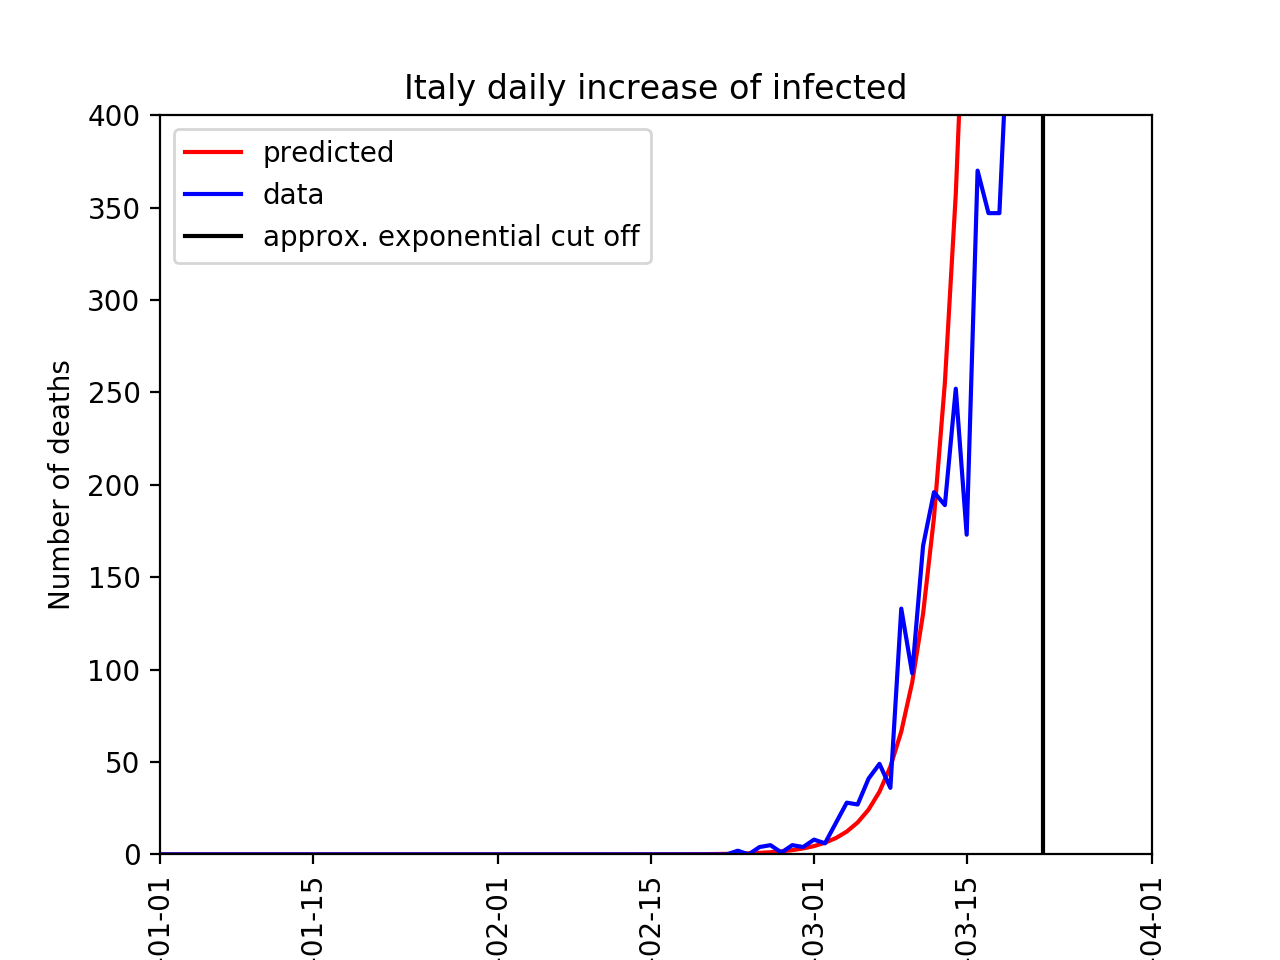

<IPython.core.display.Javascript object>


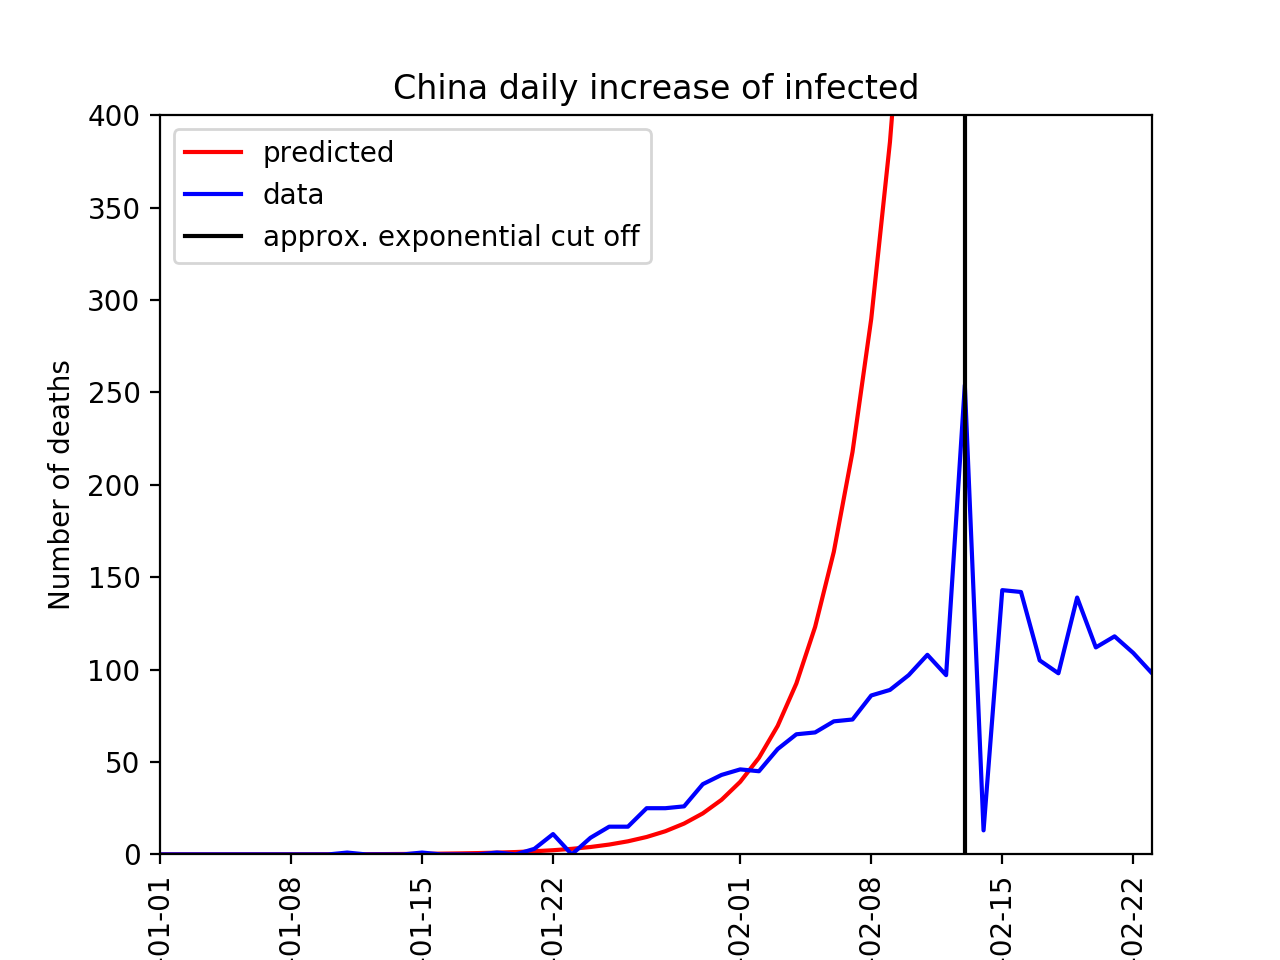

<IPython.core.display.Javascript object>


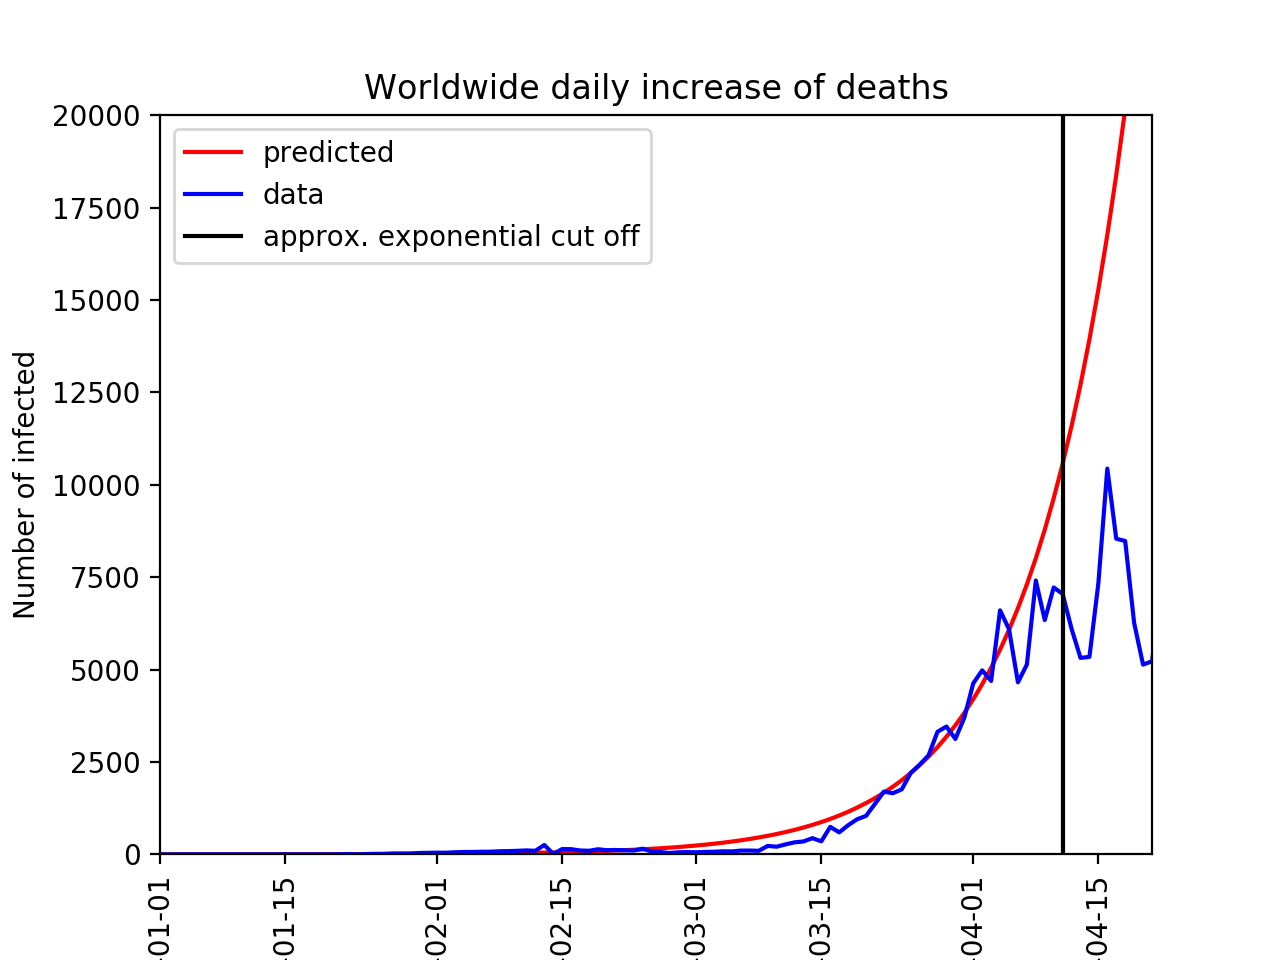

Death Growth Rate of China 0.2854856842098406
Death Growth Rate of United States of Ameria 0.2955501782529415
Death Growth Rate of Spain 0.46100805688254093
Death Growth Rate Worldwide 0.0922775780168479


,Growth Rate,intercepts,pR2,std_error,cut_offs,tot_infected
0,0.092278,-0.146915,0.001436,0.045666,101,216558.0


In [75]:
# deaths
top_d = countries_deaths_results.sort_values(by=["tot_infected"],ascending=False).index[:3]
for s in ["United States of America","Spain","Italy","China"]:
    plt.figure()
    plt.xlim(pd.Timestamp("2020-01-01"),countries[s].index[countries_deaths_results["cut_offs"][s]+10])
    plt.ylim((0,400))
    plt.title(s+" daily increase of infected")
    plt.plot(c_d_pred[s],color="red",label="predicted")
    plt.plot(countries[s]["di_deaths"],color = "blue",label="data")
    plt.axvline(x=countries[s].index[countries_deaths_results["cut_offs"][s]],color="black",label="approx. exponential cut off")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Number of deaths")
    plt.xticks(rotation=90)
# plot world - pred & data & cutoff
plt.figure()
plt.xlim(pd.Timestamp("2020-01-01"),world.index[world_deaths_results["cut_offs"]+10])
plt.ylim((0,20000))
plt.title("Worldwide daily increase of deaths")
plt.plot(w_d_pred[0],color="red",label="predicted")
plt.plot(world["di_deaths"],color = "blue",label="data")
plt.axvline(x=world.index[world_deaths_results["cut_offs"]],color="black",label="approx. exponential cut off")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of infected")
plt.xticks(rotation=90)

print("Death Growth Rate of China",countries_deaths_results["Growth Rate"]["China"])
print("Death Growth Rate of United States of Ameria",countries_deaths_results["Growth Rate"]["United States of America"])
print("Death Growth Rate of Spain",countries_deaths_results["Growth Rate"]["Spain"])
print("Death Growth Rate Worldwide",world_deaths_results["Growth Rate"][0])


In [73]:
# Spearman's Rank correlation
country_i_matrix = pd.DataFrame({"Growth Rate":countries_infected_results["Growth Rate"],"Population":0,"Population density":0,"Days since first case":pd.Timestamp("2020-01-01"),"Total infected":0},index=countries_infected_results.index)
for n in countries_infected_results.index:
    country_i_matrix.loc[n,"Population"] = countries_stats[n][0]
    country_i_matrix.loc[n,"Population density"] = countries_stats[n][1]
    country_i_matrix.loc[n,"Days since first case"] = 116 - countries_stats[n][2]
    country_i_matrix.loc[n,"Total infected"] = countries_stats[n][3]
# print(country_i_matrix.isnull().any())
country_i_matrix.drop(country_i_matrix["Population density"][country_i_matrix["Population density"].isnull()].index,inplace=True)
c_i_corr,c_i_pval = ss.spearmanr(country_i_matrix)
c_i_corr = c_i_corr[0,1:]
c_i_pval = c_i_pval[0,1:]
print("country infected",c_i_corr,c_i_pval)

country_d_matrix = pd.DataFrame({"Growth Rate":countries_deaths_results["Growth Rate"],"Population":0,"Population density":0,"Days since first case":pd.Timestamp("2020-01-01"),"Total infected":0},index=countries_deaths_results.index)
for n in countries_deaths_results.index:
    country_d_matrix.loc[n,"Population"] = countries_stats[n][0]
    country_d_matrix.loc[n,"Population density"] = countries_stats[n][1]
    country_d_matrix.loc[n,"Days since first case"] = 117 - countries_stats[n][2]
    country_d_matrix.loc[n,"Total infected"] = countries_stats[n][3]
c_d_corr,c_d_pval = ss.spearmanr(country_d_matrix)
c_d_corr = c_d_corr[0,1:]
c_d_pval = c_d_pval[0,1:]
print("country deaths",c_d_corr,c_d_pval)

country infected [0.07021579 0.02106679 0.31187296 0.45134676] [3.77618387e-01 7.91459304e-01 5.95516760e-05 2.09816520e-09]
country deaths [-0.02266155  0.0065198   0.29791866  0.51445922] [8.44902247e-01 9.55122100e-01 8.50061876e-03 1.69920864e-06]


In [69]:
country_i_matrix["Population density"][country_i_matrix["Population density"].isnull()]

Cape Verde       NaN
Faeroe Islands   NaN
Guernsey         NaN
Jersey           NaN
Monaco           NaN
Palestine        NaN
Kosovo           NaN
Sudan            NaN
South Sudan      NaN
Sint Maarten     NaN
Taiwan           NaN
Name: Population density, dtype: float64